In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import scipy.optimize as opt
import import_ipynb

In [33]:

# Setup the parameters will used for this part of the exercise
input_layer_size = 400  # 20x20 input images of Digits
hidden_layer_size = 25  # 25 hidden layers
num_labels = 10         # 10 labels, from 0 to 9
                        # Note that we have mapped "0" to label 10

In [34]:
def display_data(x):
    (m, n) = x.shape

    # Set example_width automatically if not passed in
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)

    # Compute the number of items to display
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),
                              pad + display_rows * (example_height + pad)))

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break

            # Copy the patch
            # Get the max value of the patch
            max_val = np.max(np.abs(x[curr_ex]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height),
                          pad + i * (example_width + pad) + np.arange(example_width)[:, np.newaxis]] = \
                          x[curr_ex].reshape((example_height, example_width)) / max_val
            curr_ex += 1

        if curr_ex > m:
            break

    # Display image
    plt.figure()
    plt.imshow(display_array, cmap='gray', extent=[-1, 1, -1, 1])
    plt.axis('off')


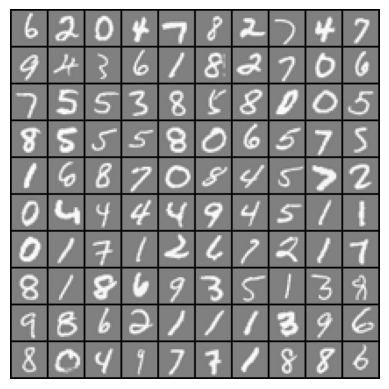

In [35]:
data = scio.loadmat('ex4data1.mat')
X = data['X']
y = data['y'].flatten()
m = y.size

# Randomly select 100 data points to display
rand_indices = np.random.permutation(range(m))
selected = X[rand_indices[0:100], :]

display_data(selected)

In [17]:
# ===================== Part 2: Loading Parameters =====================
# In this part of the exercise, we load some pre-initiated
# neural network parameters
data = scio.loadmat('ex4weights.mat')
theta1 = data['Theta1']
theta2 = data['Theta2']

nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])

In [24]:
def sigmoid(z):
    
    h=1/(1+np.exp(-z))
    return h

In [71]:
# ===================== Part 5: Sigmoid Gradient =====================
def sigmoid_gradient(z):
    g = np.zeros(z.shape)

    g=sigmoid(z)*(1-sigmoid(z))

    return g

In [27]:
def predict(theta1, theta2, x):
    # Useful values                                               m:number of examples (images)
                                                                # n:number of input features
    m = x.shape[0]                                          # d(i) :number of neurans in layer i
    num_labels = theta2.shape[0]

    # You need to return the following variable correctly
    p = np.zeros(m)
    a1= np.c_[np.ones(m), x]    # a1 (m,n+1)
    z2=np.dot(a1,theta1.T)     # z2(m,d1)
    a2=sigmoid(z2)
    a2=np.c_[np.ones(m),a2]   #a2 (m,d1+1)
    z3=np.dot(a2,theta2.T)       #z3 (m,d2) 
    a3=sigmoid(z3)             #a3 (m,d2)
    p=np.argmax(a3, axis=1)
    p=np.add(1,p)
    return p

In [115]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd):
    # Reshape nn_params back into the parameters theta1 and theta2, the weight 2-D arrays
    # for our two layer neural network
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

    # Useful value
    m = y.size
    # ouput will be (5000,10)
    one_hot_matrix=np.zeros((m,num_labels))
    for i , label in enumerate(y):
        
        one_hot_matrix[i,label-1]=1
    y=one_hot_matrix

    
    cost = 0
    theta1_grad = np.zeros(theta1.shape)  # 25 x 401
    theta2_grad = np.zeros(theta2.shape)  # 10 x 26

    # feed forward 
    a1= np.c_[np.ones(m), X]    # a1 (m,n+1)
    z2=np.dot(a1,theta1.T)     # z2(m,d1)
    a2=sigmoid(z2)
    a2=np.c_[np.ones(m),a2]   #a2 (m,d1+1)
    z3=np.dot(a2,theta2.T)       #z3 (m,d2) 
    h=sigmoid(z3)             #h (m,d2)

    #Regularized cost function 
    log_h=np.log(h)
    h_1=np.subtract(1,h)
    log_h_1=np.log(h_1)
    y_1=np.subtract(1,y)
    
    J=np.subtract(-y * log_h, y_1 * log_h_1)
    cost=(1/m)*np.sum(J)
    R=(lmd/(2*m))*(np.sum(theta1[:,1:]**2)+np.sum(theta2[:,1:]**2))
    cost_reg=cost+R

    #back propagation
    E3=h-y #(5000,10)
    E2=np.dot(E3,theta2) * (a2 * np.subtract(1, a2)) #(5000,26) 
    E2=E2[:,1:]   # remove intercept coloumn
    delta1 = np.dot(E2.T, a1)  # (25 x 401)  unregularize grade of theta1
    delta2 = np.dot(E3.T, a2)  # (10 x 26)   unregularize grade of theta1
    grad_theta1=(1/m)*delta1
    grad_theta2=(1/m)*delta2
    grad_theta1[:,1:]=grad_theta1[:,1:]+(lmd/m)*theta1[:,1:]
    grad_theta2[:,1:]=grad_theta2[:,1:]+(lmd/m)*theta2[:,1:]

    # ====================================================================================
    # Unroll gradients
    grad = np.concatenate([grad_theta1.flatten(), grad_theta2.flatten()])

    
    return cost_reg , grad
    

In [86]:
def rand_initialization(l_in, l_out):
    
    w = np.zeros((l_out, 1 + l_in))

    epsilon_init=0.12
    
    w=np.random.uniform(-epsilon_init,epsilon_init,size=(l_out,l_in+1))

    return w

In [94]:
def debug_initialize_weights(fan_out, fan_in):
    w = np.zeros((fan_out, 1 + fan_in))

    w = np.sin(np.arange(w.size)).reshape(w.shape) / 10

    return w

In [95]:
def compute_numerial_gradient(cost_func, theta):
    numgrad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)

    e = 1e-4

    for p in range(theta.size):
        perturb[p] = e
        loss1, grad1 = cost_func(theta - perturb)
        loss2, grad2 = cost_func(theta + perturb)

        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0

    return numgrad

In [96]:
def check_nn_gradients(lmd):

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generatesome 'random' test data
    theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta2 = debug_initialize_weights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to genete X
    X = debug_initialize_weights(m, input_layer_size - 1)
    y = 1 + np.mod(np.arange(1, m + 1), num_labels)

    # Unroll parameters
    nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])

    def cost_func(p):
        return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)

    cost, grad = cost_func(nn_params)
    numgrad = compute_numerial_gradient(cost_func, nn_params)

    print(np.c_[grad, numgrad])

In [97]:
# ===================== Part 6: Initializing Parameters =====================
initial_theta1 = rand_initialization(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialization(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_theta1.flatten(), initial_theta2.flatten()])

In [90]:
# ===================== Part 7: Implement Backpropagation =====================

In [110]:
# Check gradients by running check_nn_gradients()

lmd = 0
check_nn_gradients(lmd)

[[ 9.01303866e-03  9.01303866e-03]
 [-6.08047127e-05 -6.08047124e-05]
 [-6.96665817e-06 -6.96665836e-06]
 [ 5.32765097e-05  5.32765121e-05]
 [ 1.17193332e-02  1.17193332e-02]
 [-7.05495376e-05 -7.05495373e-05]
 [ 1.66652194e-04  1.66652196e-04]
 [ 2.50634667e-04  2.50634669e-04]
 [ 3.66087511e-03  3.66087511e-03]
 [-1.54510225e-05 -1.54510182e-05]
 [ 1.86817175e-04  1.86817173e-04]
 [ 2.17326523e-04  2.17326523e-04]
 [-7.76550109e-03 -7.76550108e-03]
 [ 5.38947948e-05  5.38947931e-05]
 [ 3.53029178e-05  3.53029161e-05]
 [-1.57462990e-05 -1.57462976e-05]
 [-1.20637760e-02 -1.20637760e-02]
 [ 7.36351996e-05  7.36352002e-05]
 [-1.48712777e-04 -1.48712773e-04]
 [-2.34334912e-04 -2.34334914e-04]
 [ 3.02286353e-01  3.02286353e-01]
 [ 1.51010770e-01  1.51010770e-01]
 [ 1.45233242e-01  1.45233242e-01]
 [ 1.58998192e-01  1.58998192e-01]
 [ 1.46779086e-01  1.46779086e-01]
 [ 1.48987769e-01  1.48987769e-01]
 [ 9.95931723e-02  9.95931723e-02]
 [ 4.96122519e-02  4.96122519e-02]
 [ 4.83540132e-02  4

In [106]:
# ===================== Part 9: Training NN =====================

In [111]:
lmd = 1


def cost_func(p):
    return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[0]


def grad_func(p):
    return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[1]

nn_params, *unused = opt.fmin_cg(cost_func, fprime=grad_func, x0=nn_params, maxiter=400, disp=True, full_output=True)

# Obtain theta1 and theta2 back from nn_params
theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

         Current function value: 0.308176
         Iterations: 400
         Function evaluations: 957
         Gradient evaluations: 957


C:\Users\Elmostafa\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


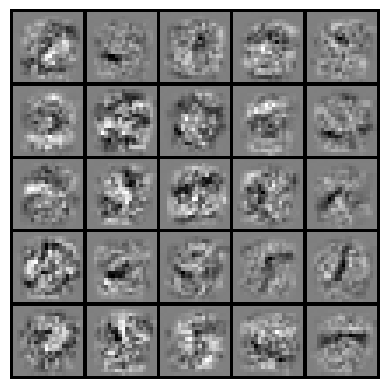

In [113]:
# ===================== Part 10: Visualize Weights =====================
display_data(theta1[:, 1:])

In [114]:
pred = predict(theta1, theta2, X)

print('Training set accuracy: {}'.format(np.mean(pred == y)*100))

Training set accuracy: 99.56
